In [44]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [45]:
import cv2
import numpy as np

def preprocess_image(path, target_size=28):
    # Đọc ảnh từ đường dẫn
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Nếu không đọc được ảnh → trả về None
    if img is None:
        return None
    # Resize ảnh về kích thước 28x28
    resized = cv2.resize(img, (target_size, target_size), interpolation=cv2.INTER_AREA)
    # Chuẩn hóa giá trị pixel về khoảng [0, 1]
    normalized = resized.astype('float32') / 255.0
   
    # Thêm batch dimension (1, 28, 28, 3)
    normalized = np.expand_dims(normalized, axis=0)
    return normalized


In [46]:
def load_data_from_folder(root_dir):
    import os
    import numpy as np

    x_data = []
    y_data = []

    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            file_path = os.path.join(label_path, filename)
            processed = preprocess_image(file_path)

            if processed is not None:
                x_data.append(processed[0])      # bỏ batch dim → (28, 28, 1)
                y_data.append(int(label))

    x_data = np.array(x_data)
    y_data = np.array(y_data)

    return x_data, y_data


In [47]:
root_dir = r"C:\Users\ADMIN\Desktop\ML\sort_images\sort_images"

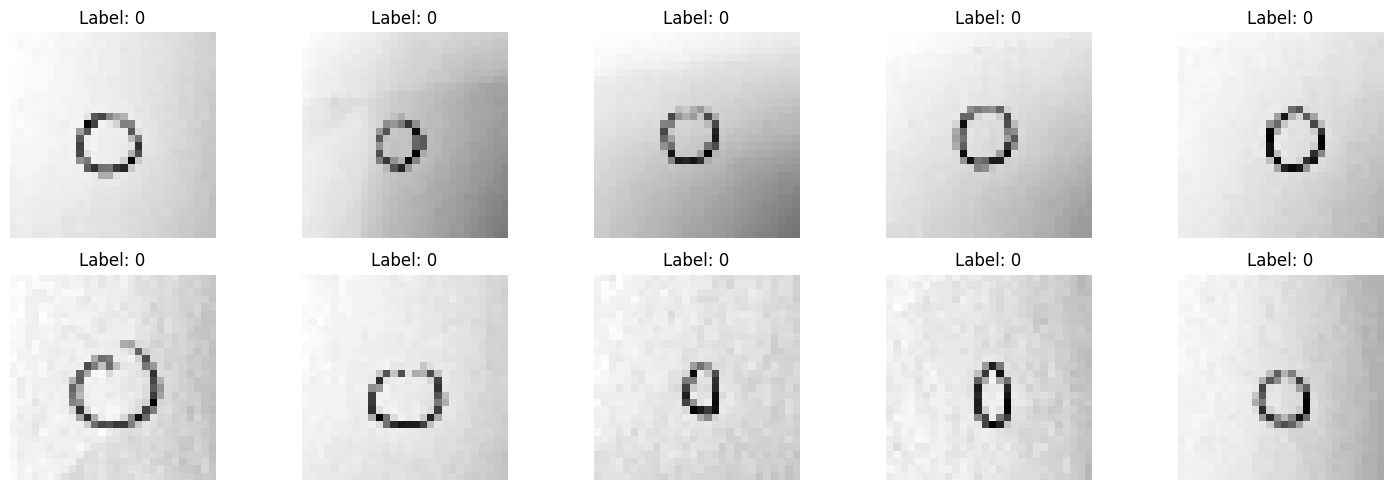

In [48]:
import matplotlib.pyplot as plt
# Giả sử bạn đã load dữ liệu bằng hàm load_data_from_folder
x_data, y_data = load_data_from_folder(root_dir)
# Tạo figure với kích thước lớn để hiển thị ảnh (chiều ngang 15 inch, chiều cao 5 inch)
plt.figure(figsize=(15, 5))
# Hiển thị 10 ảnh đầu tiên trong dữ liệu
for i in range(10):
    # Tạo subplot tại vị trí i+1 trong lưới 2 hàng x 5 cột
    plt.subplot(2, 5, i + 1)
    # Hiển thị ảnh thứ i (squeeze để loại bỏ chiều dư thừa (1,28,28,1) → (28,28))
    plt.imshow(x_data[i].squeeze(), cmap='gray')
    # Đặt tiêu đề là nhãn tương ứng
    plt.title(f"Label: {y_data[i]}")
    # Tắt hiển thị trục x/y
    plt.axis('off')
# Tự động căn chỉnh layout cho đẹp
plt.tight_layout()
# Hiển thị hình ảnh
plt.show()

In [49]:
# Lớp mạng nơ-ron tích chập (CNN)
# Input có kích thước: (batch_size, 1, 28, 28)
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # Lớp tích chập 1: input 1 channel (gray), output 32 channels, kernel 3x3
        self.conv1 = nn.Conv2d(1, 32, 3)
        # Lớp pooling: giảm kích thước ảnh bằng max pooling 2x2
        self.pool = nn.MaxPool2d(2, 2)
        # Lớp tích chập 2: input 32 channels, output 64 channels, kernel 3x3
        self.conv2 = nn.Conv2d(32, 64, 3)
        # Fully connected layer 1:
        # Sau 2 lần conv + pooling, ảnh (28x28) → (5x5) với 64 kênh
        # 64 * 5 * 5 = 1600 node đầu vào
        self.fc1 = nn.Linear(64 * 5 * 5, 64)
        # Fully connected layer 2: output 10 lớp tương ứng với 10 chữ số (0–9)
        self.fc2 = nn.Linear(64, 10)
    def forward(self, x):
        # Áp dụng conv1 → ReLU → pooling
        x = self.pool(F.relu(self.conv1(x)))
        # Áp dụng conv2 → ReLU → pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten: biến tensor thành vector để đưa vào fully connected layer
        x = torch.flatten(x, 1)
        # FC1 → ReLU
        x = F.relu(self.fc1(x))
        # FC2 → đầu ra chưa chuẩn hóa (logits)
        x = self.fc2(x)
        return x

In [50]:
# Hàm huấn luyện mô hình cho 1 epoch
def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Đặt mô hình ở chế độ huấn luyện (train mode)
    running_loss = 0.0  # Tổng loss trong epoch
    correct = 0         # Số lượng dự đoán đúng
    total = 0           # Tổng số mẫu
    # Duyệt qua từng batch trong dataloader
    for images, labels in train_loader:
        # Đưa dữ liệu lên GPU (nếu có)
        images, labels = images.to(device), labels.to(device)
        # Reset gradient của các tham số
        optimizer.zero_grad()
        # Truyền ảnh vào mô hình để lấy output
        outputs = model(images)
        # Tính loss giữa output và ground truth (nhãn thật)
        loss = criterion(outputs, labels)
        # Lan truyền ngược gradient
        loss.backward()
        # Cập nhật trọng số bằng optimizer
        optimizer.step()
        # Cộng dồn loss để tính trung bình sau này
        running_loss += loss.item()
        # Lấy nhãn dự đoán từ output (chọn class có xác suất cao nhất)
        _, predicted = torch.max(outputs, 1)
        # Tăng tổng số mẫu và số mẫu đúng
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Tính loss trung bình trên toàn bộ tập train
    avg_loss = running_loss / len(train_loader)
    # Tính accuracy (% mẫu dự đoán đúng)
    acc = 100 * correct / total
    # In loss (accuracy sẽ in ở ngoài nếu cần)
    print(f"Train loss: {avg_loss:.4f} ")
    # Trả về loss và accuracy để dùng trong quá trình theo dõi huấn luyện
    return avg_loss, acc

# Hàm test đánh giá
from collections import defaultdict
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Hàm test: đánh giá mô hình trên tập kiểm thử (test_loader)
# Tham số:
# - model: mô hình đã huấn luyện
# - test_loader: DataLoader chứa dữ liệu test
# - criterion: hàm mất mát (loss function)
# - device: CPU hoặc GPU
# - verbose: nếu True thì in thêm độ chính xác từng số và hiển thị ma trận nhầm lẫn

def test(model, test_loader, criterion, device, verbose=False):
    model.eval()  # Đặt mô hình ở chế độ đánh giá (không học, tắt dropout, batchnorm)   
    correct = 0        # Tổng số dự đoán đúng
    total = 0          # Tổng số mẫu
    loss_total = 0.0   # Tổng loss
    class_correct = defaultdict(int)  # Số lượng đúng theo từng lớp
    class_total = defaultdict(int)    # Tổng số mẫu theo từng lớp
    all_preds = []     # Danh sách toàn bộ dự đoán
    all_labels = []    # Danh sách toàn bộ nhãn thật
    with torch.no_grad():  # Tắt gradient để tăng tốc và tiết kiệm bộ nhớ khi test
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # Truyền ảnh qua mô hình → lấy dự đoán đầu ra
            outputs = model(images)
            # Tính loss của batch hiện tại
            loss = criterion(outputs, labels)
            loss_total += loss.item()
            # Lấy class có xác suất cao nhất
            _, predicted = torch.max(outputs, 1)
            # Cộng tổng số mẫu và số đúng
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Lưu kết quả để tạo confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # Cập nhật đúng/sai theo từng nhãn
            for i in range(len(labels)):
                label = labels[i].item()
                pred = predicted[i].item()
                if label == pred:
                    class_correct[label] += 1
                class_total[label] += 1
    # Tính loss trung bình toàn bộ test set
    avg_loss = loss_total / len(test_loader)
    # Tính độ chính xác tổng thể (% đúng)
    acc = 100 * correct / total
    print(f"\nTest loss: {avg_loss:.4f} - Accuracy: {acc:.2f}%")
    # Nếu bật chế độ verbose, in chi tiết hơn
    if verbose:
        print("\n🎯 Độ chính xác theo từng chữ số:")
        for digit in range(10):
            if class_total[digit] > 0:
                acc_digit = 100 * class_correct[digit] / class_total[digit]
                print(f"   - Số {digit}: {acc_digit:.2f}% ({class_correct[digit]}/{class_total[digit]})")
            else:
                print(f"   - Số {digit}: Không có dữ liệu test")
        # Vẽ ma trận nhầm lẫn (confusion matrix)
        print("\n🧩 Ma trận nhầm lẫn:")
        cm = confusion_matrix(all_labels, all_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix - Epoch Cuối")
        plt.show()
    return avg_loss, acc  # Trả về loss và accuracy

In [61]:
import os
import torch
import pandas as pd
from torchvision import transforms
import numpy as np

def predict_digits_from_folder(model, input_folder, output_csv, device='cpu'):
    model.eval()  # Chế độ đánh giá
    results = []

    for filename in sorted(os.listdir(input_folder)):
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        file_path = os.path.join(input_folder, filename)
        processed = preprocess_image(file_path)  # (1, 28, 28) hoặc (1, 28, 28, 1)

        if processed is None:
            print(f"⚠️ Bỏ qua ảnh lỗi: {filename}")
            continue

        # Xử lý shape: (1, 28, 28) → (1, 1, 28, 28) nếu thiếu channel
        if processed.ndim == 3:
            processed = np.expand_dims(processed, axis=1)  # (1, 28, 28) → (1, 1, 28, 28)
        elif processed.ndim == 4 and processed.shape[-1] == 1:
            processed = processed.transpose(0, 3, 1, 2)  # (1, 28, 28, 1) → (1, 1, 28, 28)
        elif processed.ndim == 4 and processed.shape[-1] == 3:
            processed = processed.transpose(0, 3, 1, 2)  # (1, 28, 28, 3) → (1, 3, 28, 28)

        # Convert sang tensor
        input_tensor = torch.tensor(processed, dtype=torch.float32).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            predicted_label = torch.argmax(output, dim=1).item()

        results.append([filename, predicted_label])

    # Ghi kết quả
    df = pd.DataFrame(results, columns=["filename", "predicted_label"])
    df.to_csv(output_csv, index=False)
    print(f"✅ Đã ghi kết quả vào: {output_csv}")


In [52]:
# Load dữ liệu
x_data, y_data = load_data_from_folder(root_dir)
print(f"Số ảnh đã load: {len(x_data)}")
print(f"Shape x_data: {x_data.shape}")
print(f"Shape y_data: {y_data.shape}")

Số ảnh đã load: 6747
Shape x_data: (6747, 28, 28)
Shape y_data: (6747,)


In [53]:
# Chia train/test
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y_data, test_size=0.2, stratify=y_data, random_state=42
)

In [55]:
# Thêm kênh màu cho ảnh: (N, 28, 28) → (N, 1, 28, 28)
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)

# Chuyển ảnh sang tensor float32
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# Chuyển nhãn sang tensor long (phù hợp cho CrossEntropyLoss)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)



In [56]:
# Tạo DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000)


Epoch 1
Train loss: 2.3043 

Test loss: 2.3024 - Accuracy: 9.93%

Epoch 2
Train loss: 2.3022 

Test loss: 2.2998 - Accuracy: 11.56%

Epoch 3
Train loss: 2.2899 

Test loss: 2.2740 - Accuracy: 16.07%

Epoch 4
Train loss: 2.2111 

Test loss: 2.1685 - Accuracy: 22.81%

Epoch 5
Train loss: 2.1056 

Test loss: 2.1021 - Accuracy: 27.56%

Epoch 6
Train loss: 2.0320 

Test loss: 2.0426 - Accuracy: 32.96%

Epoch 7
Train loss: 1.9723 

Test loss: 1.9882 - Accuracy: 35.85%

Epoch 8
Train loss: 1.9029 

Test loss: 1.9281 - Accuracy: 38.44%

Epoch 9
Train loss: 1.8262 

Test loss: 1.8564 - Accuracy: 41.78%

Epoch 10
Train loss: 1.7487 

Test loss: 1.7803 - Accuracy: 45.41%

Epoch 11
Train loss: 1.6793 

Test loss: 1.7333 - Accuracy: 45.85%

Epoch 12
Train loss: 1.6119 

Test loss: 1.6596 - Accuracy: 49.33%

Epoch 13
Train loss: 1.5432 

Test loss: 1.6377 - Accuracy: 50.59%

Epoch 14
Train loss: 1.5052 

Test loss: 1.5917 - Accuracy: 51.78%

Epoch 15
Train loss: 1.4563 

Test loss: 1.5502 - Accurac

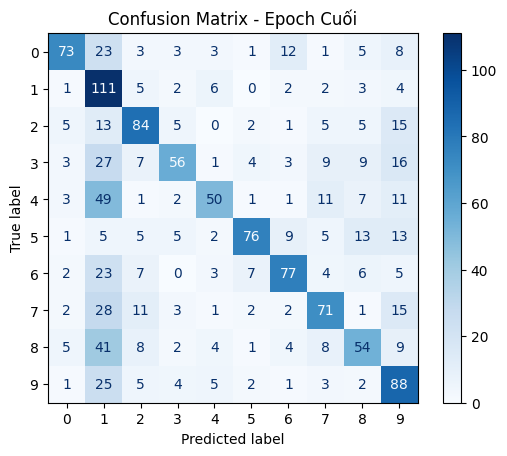

In [57]:
# Chọn thiết bị chạy: Ưu tiên GPU nếu có, không thì dùng CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Khởi tạo mô hình và đưa lên thiết bị
model = Net().to(device)
# Chọn hàm mất mát: CrossEntropyLoss phù hợp cho bài toán phân loại đa lớp
criterion = nn.CrossEntropyLoss()
# Khởi tạo optimizer Adam với learning rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Import thư viện vẽ biểu đồ
import matplotlib.pyplot as plt
# Danh sách lưu loss và accuracy để theo dõi quá trình huấn luyện
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

# Huấn luyện mô hình trong 20 epoch
for epoch in range(1, 21):
    print(f"\nEpoch {epoch}")
    # --- Huấn luyện trên tập train ---
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    # --- Đánh giá trên tập test ---
    is_last = (epoch == 20)  # Chỉ in chi tiết ở epoch cuối
    test_loss, test_acc = test(model, test_loader, criterion, device, verbose=is_last)
    # Ghi lại kết quả để vẽ biểu đồ sau
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

In [58]:
# độ chính xác của tập test tăng dần theo từng epoch tuy nhiên đến một số lượng epoch nào đó độ chính xác sẽ tăng chậm (hầu như ko thay đổi) đó chính 
# độ chính xác tối đa của mô hình 

# theo ma trận nhầm lẫn ta thấy được các ô đường chéo chính của ma trận chiếm số lượng lớn nhấ trong các hàng cho thấy khả năng dự đoán của mô hình 
# tương đối tốt 
# Bên cạnh đó vẫn còn một số ô trong các hàng ngang vẫn còn giá trị cao cho thấy các số dẽ bị nhầm lẫn nhau 
# số 0 dễ bị nhầm lẫn thành số 8 (11 lần)
# số 1 đẽ bị nhầm lẫn thành số 4 (11 lần)
# số 2 dễ bị nhầm lẫn thành số 3 (8 lần)
# số 3 dễ bị nhầm lẫn thành số 1,2,9(7 lần )
# số 4 dễ bị nhầm lẫn thành số 2 (18 lần)
# số 5 dễ bị nhầm lẫn thành số 3 (8 lần)
# số 6 dễ bị nhầm lẫn thành số 1 (11 lần) và số 8 (10 lần)
# số 7 dễ bị nhầm lẫn thành số 1,2 (10 và 11 lần)
# số 8 dễ bị nhầm lẫn thành số 6 (19 lần)
# số 9 dễ bị nhầm lẫn thành số 4 (9 lần)
# và theo độ chính xác ở epoch cuối cùng thì trong bài toán này các số có độ chính xác cao là : 1,2,5
# và theo độ chính xác ở epoch cuối cùng thì trong bài toán này các số có độ chính xác thấp là : 3,7

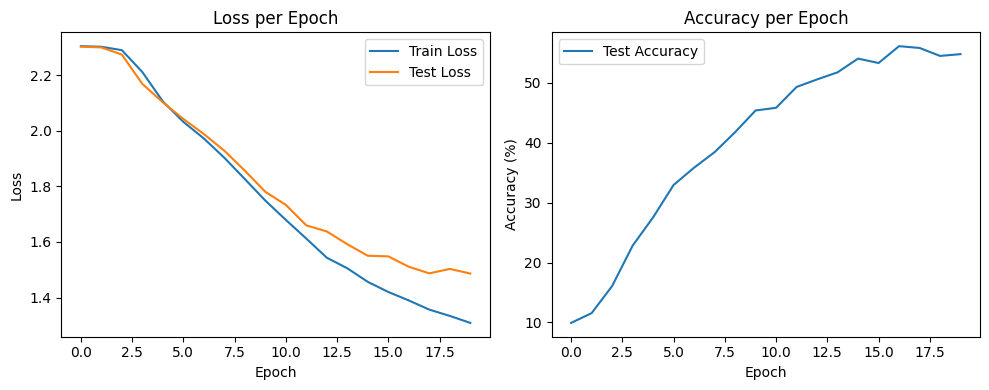

In [59]:
# Vẽ biểu đồ loss và accuracy
plt.figure(figsize=(10, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
#plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

In [62]:
# Dự đoán trên folder ảnh mới
INPUT_FOLDER = r"C:\Users\ADMIN\Desktop\ML\data.2025"
OUTPUT_CSV   = r"C:\Users\ADMIN\Desktop\ML\sub.csv"


predict_digits_from_folder(model, INPUT_FOLDER, OUTPUT_CSV, device=device)

⚠️ Bỏ qua ảnh lỗi: 21151445fd63ff79440449974f17109d.jpg
⚠️ Bỏ qua ảnh lỗi: 2c18ee0e7cea8354149df435532d74ae.jpeg
⚠️ Bỏ qua ảnh lỗi: 3a816aa78f56749a0822d700ff560924.jpeg
⚠️ Bỏ qua ảnh lỗi: 4abc1b5dcf1be1de6503dc072e132fa0.jpeg
⚠️ Bỏ qua ảnh lỗi: 70ebf0bec317006017a54d6c9172af45.jpeg
⚠️ Bỏ qua ảnh lỗi: 8eeee227b3f244e980b747387bc79bf2.jpeg
⚠️ Bỏ qua ảnh lỗi: 9e748b9617e26b90011f8d7c3f8a7eee.jpeg
⚠️ Bỏ qua ảnh lỗi: a008f795ae8498751f2e5feeb0b73387.jpeg
⚠️ Bỏ qua ảnh lỗi: ce2388179ec73203a60d8efedd04e0f1.jpeg
⚠️ Bỏ qua ảnh lỗi: d4b080c6ce4933f1199fad7f75e7d112.jpeg
⚠️ Bỏ qua ảnh lỗi: e21dcb1cb0571a21a013b4232d1b6a13.jpeg
⚠️ Bỏ qua ảnh lỗi: f7679411e290bfd8dc90b3eadb57460a.jpeg
⚠️ Bỏ qua ảnh lỗi: ffd4f9df7163f55474a0182265c8d810.jpeg
✅ Đã ghi kết quả vào: C:\Users\ADMIN\Desktop\ML\sub.csv
